#### XGBoost in Python

Let's give a summary of the XGBoost machine learning model before we dive into it. We are using the price data of US tech stocks in the US such as Apple, Amazon, Netflix, Nvidia, and Microsoft for the last sixteen years, and train the XGBoost model to predict if the next day’s returns are positive or negative.

#### Import Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

# Import XGBoost
import xgboost

# XGBoost Classifier
from xgboost import XGBClassifier

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Yahoo finance to get the data
import yfinance as yf

# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# For data manipulation
import pandas as pd
import numpy as np

#### Define Parameters

We have defined the list of stock, start date, and the end date which we will be working with in this chapter.

In [2]:
# Set the stock list
stock_list = ['AAPL', 'AMZN', 'NFLX', 'WMT', 'MSFT']

# Set the start date and the end date
start_date = '2004-1-1'
end_date = '2021-9-1'

#### Get the Data, Create Features and Target Variable

We define a list of features from which the model will pick the best ones. Here, we have the percentage change and the standard deviation with different time periods as the features. 

The target variable is the next day's return. If the next day’s return is positive we label it as 1, and if it is negative then we label it as -1. You can also try to create the target variables with three labels such as 1, 0, and -1 for long, no position and short respectively. 

Let’s see the code now. 

In [3]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}

for stock_name in stock_list:
    
    # Get the data    
    df = yf.download(stock_name, start_date, end_date)
    
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()

    # Create the features
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = \
        df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))

    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)

    df = df.dropna()

    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Before we move on to the implementation of the XGBoost Python model, let’s first plot the daily returns of Apple stored in the dictionary to see if everything is working fine.

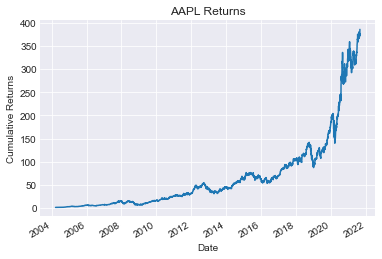

In [4]:
# Access the dataframe of AAPL from the dictionary 
# and then compute and plot the returns
(stock_data_dictionary['AAPL'].daily_pct_change+1).cumprod().plot()

# Set the title, axis lables, and plot grid
plt.title('AAPL Returns')
plt.ylabel('Cumulative Returns')
plt.show()

#### Split the Data into Train and Test<br>

Since XGBoost is after all a machine learning model, we will split the data set into test and train set.

In [5]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

for stock_name in stock_list:
    # Get features
    X = stock_data_dictionary[stock_name][predictor_list]
    
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal

    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

#### Initialising the XGBoost Machine Learning Model

We will initialise the classifier model. We will set two hyperparameters, namely max_depth and n_estimators. These are set on the lower side to reduce overfitting.

In [6]:
# Initialise the model and set the hyperparameter values
model = XGBClassifier(max_depth=2, n_estimators=30)
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

#### Create the Model

We will train the XGBoost classifier using the fit method.

In [7]:
# Fit the model
model.fit(X_train, y_train)

[09:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Since we are using most of the default parameters, you might get certain warnings depending on updates in the XGBoost library.

#### Feature Importance

We have plotted the top 7 features and sorted them based on their importance. 

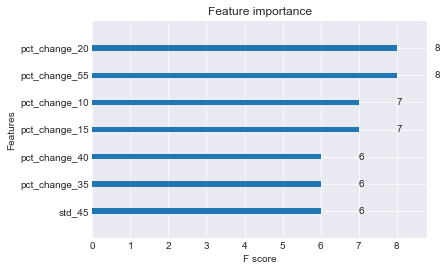

In [8]:
xgboost.plot_importance(model, max_num_features=7)

# Show the plot
plt.show()

That’s interesting. The XGBoost Python model tells us that the pct_change_40 is the most important feature than others. Since we had mentioned that we only need 7 features, we received this list. Here’s an interesting idea, why don’t you increase the number and see how the other features stack up, when it comes to their f-score. You can also remove the unimportant features and then retrain the model. Would this increase the model accuracy? I leave that for you to verify.

Anyway, onwards we go!

#### Predict the Signal

In [9]:
# Predict the trading signal on the test datset
y_pred = model.predict(X_test)

#### Classification Report

In [10]:
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.49      0.15      0.23      2044
           1       0.54      0.86      0.66      2351

    accuracy                           0.53      4395
   macro avg       0.52      0.51      0.45      4395
weighted avg       0.52      0.53      0.46      4395



Hold on! We are almost there. Let’s see what XGBoost tells us right now.

That’s interesting. The f1-score for the long side is much more powerful compared to the short side. We can modify the model and make it a long-only strategy. 

Let’s try another way to formulate how well XGBoost performed. 

#### Confusion Matrix

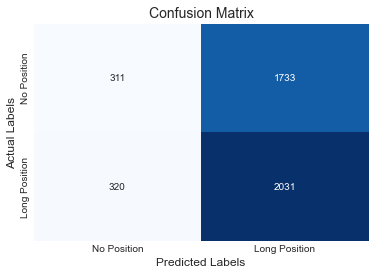

In [11]:
confusion_matrix_data = confusion_matrix(y_test, y_pred)

# Plot the data
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_matrix_data, fmt="d",
cmap='Blues', cbar=False, annot=True, ax=ax)
# Set the axes labels and the title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
ax.yaxis.set_ticklabels(['No Position', 'Long Position'])
# Display the plot
plt.show()

#### Individual Stock Performance<br>

Let’s see how the XGBoost based strategy returns held up against the normal daily returns, i.e. the buy and hold strategy. We will plot a comparison graph between the strategy returns and the daily returns for all the companies we had mentioned before. The code is as follows:

AAPL


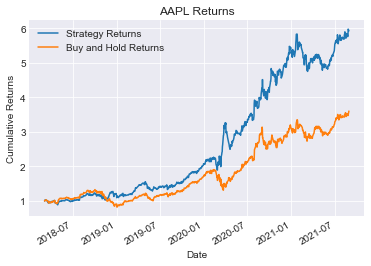

AMZN


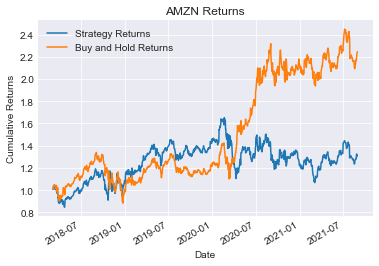

NFLX


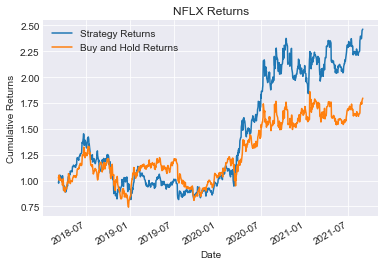

WMT


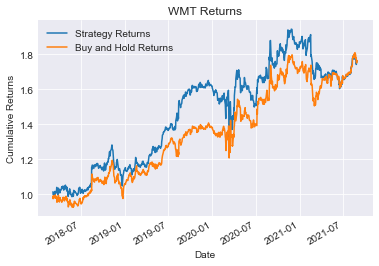

MSFT


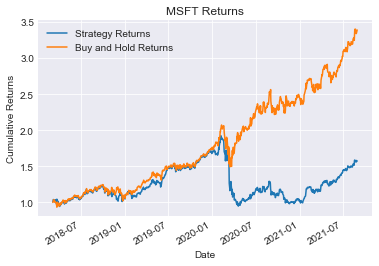

In [12]:
# Create an empty dataframe to store the strategy returns of
# individual stocks
portfolio = pd.DataFrame(columns=stock_list)

# For each stock in the stock list, plot the strategy returns
# and buy and hold returns
for stock_name in stock_list:
    
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the features in X
    X = df[predictor_list]

    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day \
                            * df.predicted_signal

    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    
    # Plot the stock strategy and buy and hold returns
    print(stock_name)    
    
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()    
    
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])    
    plt.show()

#### Performance of Portfolio

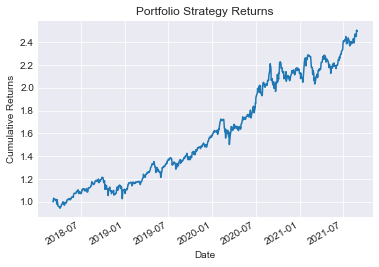

In [13]:
# Drop the missing values
portfolio.dropna(inplace=True)

# Calculate the cumulative portfolio returns by assuming 
# equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()

# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.show()

#### Conclusion

We started from the emergence of machine learning algorithms and moved to ensemble learning. We learnt about boosted trees and how they help us in making better predictions. We finally came to XGBoost machine learning model and how it is better than a regular boosted algorithm. We then went through a simple XGBoost Python code and created a portfolio based on the trading signals created by the code. In between, we also listed down feature importance as well as certain parameters included in XGBoost.